In [1]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import numpy as np
from matplotlib import pyplot as plt

fire_perimeters = "WFIGS_-_Current_Wildland_Fire_Perimeters.csv"
fire_locations = "WFIGS_-_Wildland_Fire_Locations_Full_History.csv"

In [2]:
fire_perimeters_df = pd.read_csv(fire_perimeters)
fire_locations_df = pd.read_csv(fire_locations)

C:\Users\wallh\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (13,14,32,61,64,77,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
fire_locations_df.columns

Index(['X', 'Y', 'OBJECTID', 'ABCDMisc', 'ADSPermissionState',
       'CalculatedAcres', 'ContainmentDateTime', 'ControlDateTime',
       'DailyAcres', 'DiscoveryAcres', 'DispatchCenterID',
       'EstimatedCostToDate', 'FinalFireReportApprovedByTitle',
       'FinalFireReportApprovedByUnit', 'FinalFireReportApprovedDate',
       'FireBehaviorGeneral', 'FireBehaviorGeneral1', 'FireBehaviorGeneral2',
       'FireBehaviorGeneral3', 'FireCause', 'FireCauseGeneral',
       'FireCauseSpecific', 'FireCode', 'FireDepartmentID',
       'FireDiscoveryDateTime', 'FireMgmtComplexity', 'FireOutDateTime',
       'FireStrategyConfinePercent', 'FireStrategyFullSuppPercent',
       'FireStrategyMonitorPercent', 'FireStrategyPointZonePercent',
       'FSJobCode', 'FSOverrideCode', 'GACC', 'ICS209ReportDateTime',
       'ICS209ReportForTimePeriodFrom', 'ICS209ReportForTimePeriodTo',
       'ICS209ReportStatus', 'IncidentManagementOrganization', 'IncidentName',
       'IncidentShortDescription', 'Inciden

In [5]:
fire_discovered_and_out = fire_locations_df[["FireDiscoveryDateTime", "FireOutDateTime", "IncidentName", "X", "Y", "POOState", "FireCause"]].dropna()

# Use .loc to filter for the state of california
fire_discovered_and_out = fire_discovered_and_out.loc[fire_discovered_and_out["POOState"] == "US-CA"]

fire_discovery_date_time = []
fire_out_date_time = []
fire_out_delta = []

# We loop through all the rows, converting them to datetime objects
for i in range(len(fire_discovered_and_out)):
    
    # We try to convert the discovery time and fire out time to a datetime object, if that raises an exception then
    # we instead add a null value, (that we'll drop later)
    try:
        started = pd.to_datetime(fire_discovered_and_out["FireDiscoveryDateTime"].iloc[i], format="%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_discovery_date_time.append(started)
    except:
        started = datetime.strptime(fire_discovered_and_out["FireDiscoveryDateTime"].iloc[i], "%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_discovery_date_time.append(pd.nan)
        
    try:    
        out = pd.to_datetime(fire_discovered_and_out["FireOutDateTime"].iloc[i], format="%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_out_date_time.append(out)
    except:
        out = datetime.strptime(fire_discovered_and_out["FireOutDateTime"].iloc[i], "%Y/%m/%d %H:%M:%S+%f", utc=True)
        fire_out_date_time.append(np.nan)
    
    # We also make a new column to keep track of how long the fire lasted
    # A few rows must have been improperly filled out, as the fire was put out before it started
    # So we try and if the time delta is negative, or it otherwise doesn't work we put in NaN which we will drop later
    try:
        time_delta = pd.Timedelta(out-started)
    
        if time_delta.days < 0:
            fire_out_delta.append(np.nan)
        
        else:
            fire_out_delta.append(pd.Timedelta(time_delta))
    except:
        fire_out_delta.append(np.nan)

# now we update our dataframe 
fire_discovered_and_out["FireDiscoveryDateTime"] = fire_discovery_date_time
fire_discovered_and_out["FireOutDateTime"] = fire_out_date_time
fire_discovered_and_out["FireOutDelta"] = fire_out_delta
fire_discovered_and_out.head()


,FireDiscoveryDateTime,FireOutDateTime,IncidentName,X,Y,POOState,FireCause,FireOutDelta
9,2015-06-09 03:36:00+00:00,2015-06-09 16:57:00+00:00,41,-119.693013,37.638805,US-CA,Human,0 days 13:21:00
23,2020-08-15 18:31:58+00:00,2020-08-16 15:59:59+00:00,SOUTH FORK,-122.901014,41.202338,US-CA,Human,0 days 21:28:01
24,2016-09-02 22:49:00+00:00,2016-09-04 00:59:59+00:00,Crown,-119.446513,38.114475,US-CA,Human,1 days 02:10:59
65,2018-10-09 20:36:59+00:00,2018-10-09 23:00:00+00:00,CAHUILLA,-116.769612,33.528925,US-CA,Human,0 days 02:23:01
79,2019-10-15 15:21:59+00:00,2019-10-26 20:23:59+00:00,Brannon,-123.441114,41.376505,US-CA,Unknown,11 days 05:02:00


In [6]:
# Now we dropna from this finished dataframe
fire_time_delta_cleaned = fire_discovered_and_out.dropna()

In [7]:
# Here we define a bunch of functions to return a list of fire counts broken down by month, hour and by day of a given month
# There's a much easier way to do this with groupby, but whatever

def fire_counts_by_month(data):
    fire_counts = [0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(data)):
        month = data["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").month
        fire_counts[month -1] += 1
    return fire_counts

def fire_counts_by_hour(data):
    fire_counts = []
    for i in range(24):
        fire_counts.append(0)
    
    for i in range(len(data)):
        hour = data["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").hour
        fire_counts[hour] += 1
    return fire_counts

# This one, in addition to the dataset, takes the target month as an integer and the number of days in that month
def fire_counts_by_day(data, target_month, days):
    fire_counts = []
    for i in range(days):
        fire_counts.append(0)

    for i in range(len(data)):
        month = data["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").month
        if month == target_month:
            day = fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").day
            fire_counts[day -1] += 1
    return fire_counts

[138, 182, 169, 339, 708, 1364, 2640, 1804, 1005, 577, 304, 156]


<BarContainer object of 12 artists>

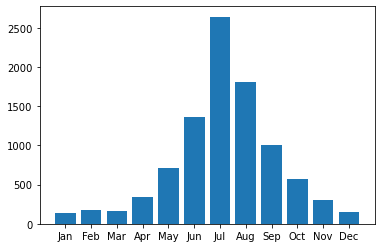

In [8]:
fire_counts = fire_counts_by_month(fire_time_delta_cleaned)
print(fire_counts)
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.bar(months, fire_counts)

[67, 59, 44, 48, 45, 86, 135, 356, 450, 506, 616, 669, 720, 823, 835, 821, 756, 740, 500, 397, 281, 185, 125, 122]


<BarContainer object of 24 artists>

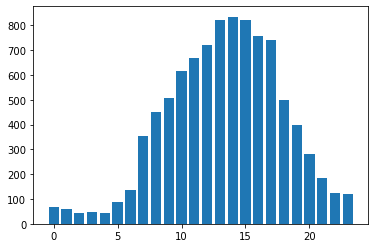

In [9]:
fire_counts = fire_counts_by_hour(fire_time_delta_cleaned)
print(fire_counts)
plt.bar(range(24), fire_counts)

<BarContainer object of 31 artists>

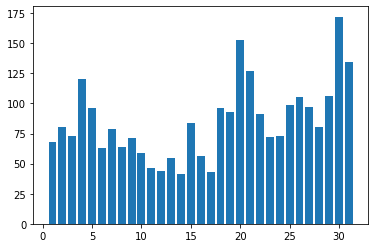

In [10]:
fire_counts = fire_counts_by_day(fire_time_delta_cleaned, 7, 31)

plt.bar(range(1, 32), fire_counts)

In [11]:
# Here we set the fireDiscoveryDateTime as the index (makes it easier to get the month, day, hour, etc.)

fire_time_delta_cleaned.index = fire_time_delta_cleaned["FireDiscoveryDateTime"]
fire_time_delta_cleaned.index.month

Int64Index([ 6,  8,  9, 10, 10,  8, 11,  8,  5,  6,
            ...
             7,  7,  7,  7,  7,  6,  7,  7,  7,  7],
           dtype='int64', name='FireDiscoveryDateTime', length=9386)

In [12]:
fire_time_delta_cleaned.groupby(fire_time_delta_cleaned.index.month).count()

,FireDiscoveryDateTime,FireOutDateTime,IncidentName,X,Y,POOState,FireCause,FireOutDelta
FireDiscoveryDateTime,,,,,,,,
1,138,138,138,138,138,138,138,138
2,181,181,181,181,181,181,181,181
3,168,168,168,168,168,168,168,168
4,340,340,340,340,340,340,340,340
5,707,707,707,707,707,707,707,707
6,1352,1352,1352,1352,1352,1352,1352,1352
7,2618,2618,2618,2618,2618,2618,2618,2618
8,1836,1836,1836,1836,1836,1836,1836,1836
9,1007,1007,1007,1007,1007,1007,1007,1007


In [13]:
fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireOutDelta"] == fire_time_delta_cleaned["FireOutDelta"].max()]

,FireDiscoveryDateTime,FireOutDateTime,IncidentName,X,Y,POOState,FireCause,FireOutDelta
FireDiscoveryDateTime,,,,,,,,
2020-09-08 13:43:51+00:00,2020-09-08 13:43:51+00:00,2022-02-01 20:00:00+00:00,SLATER,-123.353598,41.858031,US-CA,Undetermined,511 days 06:16:09


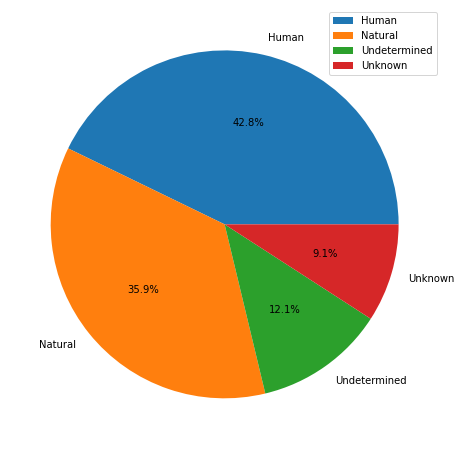

In [14]:
fire_time_delta_cleaned.groupby("FireCause").size().plot.pie(ylabel='', autopct='%1.1f%%', figsize = [8,8])
plt.legend(loc="best")

In [15]:
# Here we add hour and month columns to the dataframe to use for our groupby, localized to pacific time zone

time_of_day = []
for i in range(len(fire_time_delta_cleaned)):
    time_of_day.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").hour)

fire_time_delta_cleaned["LocalTimeOfDay"] = time_of_day

count_by_month = []
for i in range(len(fire_time_delta_cleaned)):
    count_by_month.append(fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[i].tz_convert(tz="US/Pacific").month)

fire_time_delta_cleaned["LocalMonth"] = count_by_month

C:\Users\wallh\AppData\Local\Temp/ipykernel_17344/1858043445.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_time_delta_cleaned["LocalTimeOfDay"] = time_of_day
C:\Users\wallh\AppData\Local\Temp/ipykernel_17344/1858043445.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_time_delta_cleaned["LocalMonth"] = count_by_month


In [16]:
fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[0].tz_convert(tz="US/Pacific")

Timestamp('2015-06-08 20:36:00-0700', tz='US/Pacific')

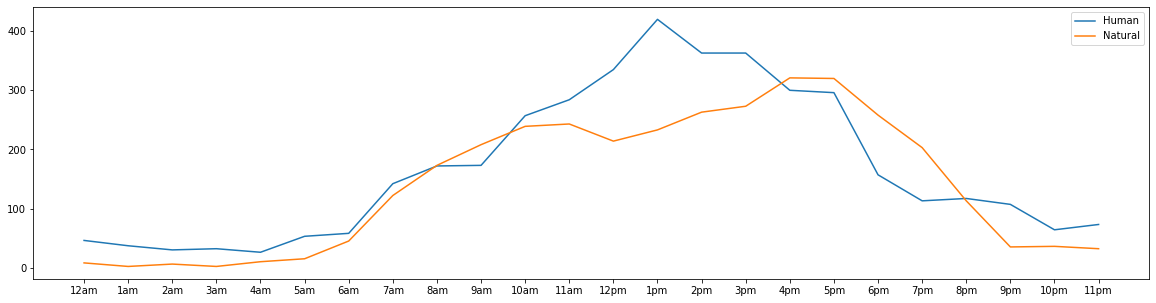

In [17]:
fire_by_time_human = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Human"].groupby("LocalTimeOfDay").size()
fire_by_time_natural = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Natural"].groupby("LocalTimeOfDay").size()
times_of_day = ["12am", "1am", "2am", "3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am", "12pm", "1pm", "2pm", "3pm", "4pm", "5pm", "6pm", "7pm", "8pm", "9pm", "10pm", "11pm"]

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(times_of_day, fire_by_time_human, label="Human")
ax.plot(times_of_day, fire_by_time_natural, label="Natural")
ax.legend()

plt.show()

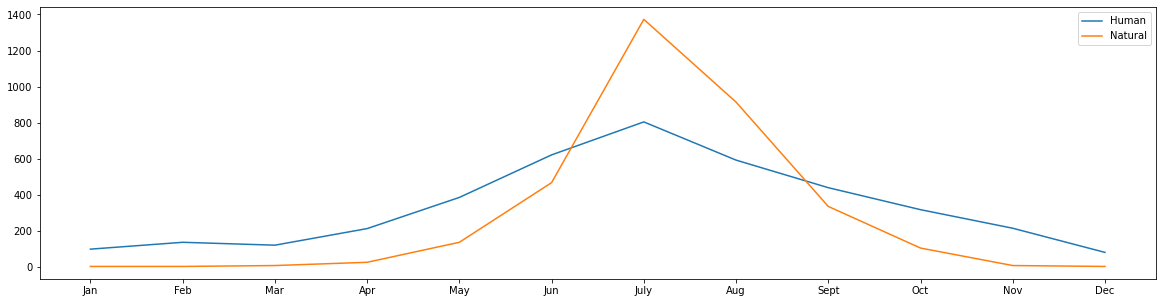

In [18]:
fire_by_month_human = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Human"].groupby("LocalMonth").size()
fire_by_month_natural = fire_time_delta_cleaned.loc[fire_time_delta_cleaned["FireCause"] == "Natural"].groupby("LocalMonth").size()
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

fig, ax = plt.subplots(figsize=(20,5))

ax.plot(months, fire_by_month_human, label="Human")
ax.plot(months, fire_by_month_natural, label="Natural")
ax.legend()

plt.show()

In [19]:
fire_time_delta_cleaned

,FireDiscoveryDateTime,FireOutDateTime,IncidentName,X,Y,POOState,FireCause,FireOutDelta,LocalTimeOfDay,LocalMonth
FireDiscoveryDateTime,,,,,,,,,,
2015-06-09 03:36:00+00:00,2015-06-09 03:36:00+00:00,2015-06-09 16:57:00+00:00,41,-119.693013,37.638805,US-CA,Human,0 days 13:21:00,20,6
2020-08-15 18:31:58+00:00,2020-08-15 18:31:58+00:00,2020-08-16 15:59:59+00:00,SOUTH FORK,-122.901014,41.202338,US-CA,Human,0 days 21:28:01,11,8
2016-09-02 22:49:00+00:00,2016-09-02 22:49:00+00:00,2016-09-04 00:59:59+00:00,Crown,-119.446513,38.114475,US-CA,Human,1 days 02:10:59,15,9
2018-10-09 20:36:59+00:00,2018-10-09 20:36:59+00:00,2018-10-09 23:00:00+00:00,CAHUILLA,-116.769612,33.528925,US-CA,Human,0 days 02:23:01,13,10
2019-10-15 15:21:59+00:00,2019-10-15 15:21:59+00:00,2019-10-26 20:23:59+00:00,Brannon,-123.441114,41.376505,US-CA,Unknown,11 days 05:02:00,8,10
...,...,...,...,...,...,...,...,...,...,...
2022-06-26 18:33:51+00:00,2022-06-26 18:33:51+00:00,2022-07-11 19:30:00+00:00,FROG,-120.008813,38.553945,US-CA,Natural,15 days 00:56:09,11,6
2022-07-11 22:18:59+00:00,2022-07-11 22:18:59+00:00,2022-07-15 19:36:00+00:00,Christian,-123.618014,40.909372,US-CA,Undetermined,3 days 21:17:01,15,7
2022-07-12 22:50:59+00:00,2022-07-12 22:50:59+00:00,2022-07-15 20:53:00+00:00,White,-119.419013,37.912135,US-CA,Undetermined,2 days 22:02:01,15,7


In [20]:
datetime.now(timezone.utc).astimezone().tzinfo

datetime.timezone(datetime.timedelta(days=-1, seconds=72000), 'Eastern Daylight Time')

In [21]:
fire_time_delta_cleaned["FireDiscoveryDateTime"].iloc[0]

Timestamp('2015-06-09 03:36:00+0000', tz='UTC')

In [22]:
fire_time_delta_cleaned.reset_index(drop=True).to_json("wildfiresCleaned.json")